# PDE-FIND for identifying Navier-Stokes with added noise

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder with artificial noise added to the solution.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


First load the data.  Plotted below is a single timepoint with red outlining the area in which points have been samples for use in the algorithm.

/home/samuel/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/samuel/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/samuel/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


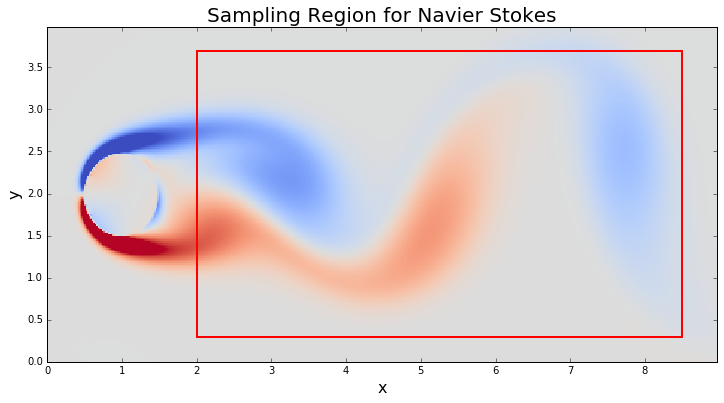

In [9]:
# Load data
data = sio.loadmat('../CYLINDER/DATA/ALL.mat')
steps = 151
n = 449
m = 199
W = data['VORTALL'].reshape(n,m,steps)   # vorticity
U = data['UALL'].reshape(n,m,steps)      # x-component of velocity
V = data['VALL'].reshape(n,m,steps)      # y-component of velocity

dt = 0.2
dx = 0.02
dy = 0.02

# plot the data
xx, yy = meshgrid(
    np.arange(449)*dx,
    np.arange(199)*dy)
pcolor(xx,yy,W[:,:,75].T,cmap='coolwarm', vmin=-4, vmax=4)

# Cut out the portion of the data before the cylinder
xmin = 100*dx
xmax = 425*dx
ymin = 15*dy
ymax = 185*dy
plot([xmin,xmin],[ymin,ymax],'r',linewidth = 2)
plot([xmax,xmax],[ymin,ymax],'r',linewidth = 2)
plot([xmin,xmax],[ymin,ymin],'r',linewidth = 2)
plot([xmin,xmax],[ymax,ymax],'r',linewidth = 2)
xlim([0,n*dx-dx])
ylim([0,m*dy])
title('Sampling Region for Navier Stokes', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)

W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

# Add in noise with magnitude equal to 1% of std dev of data
numpy.random.seed(0)
Wn = W + 0.01*np.std(W)*np.random.randn(n,m,steps)
Un = U + 0.01*np.std(U)*np.random.randn(n,m,steps)
Vn = V + 0.01*np.std(V)*np.random.randn(n,m,steps)

## Denoising using the SVD

Now denoise using the SVD.  Each snapshot in time is arranged into a column and the resulting matrix is projected onto a low dimensional subspace given by it's most dominant singular vectors.  The dimension used is determined visually from looking for a Pareto front on the singular values, which is easy to see in their plot.  Notice that compared to the clean data, the noisy data's singular values do not fall below a certain value.  We consider those lying on this flat line to correspond to the artificial noise, and throw them away.

In [3]:
W = W.reshape(n*m,steps)
U = U.reshape(n*m,steps)
V = V.reshape(n*m,steps)

Wn = Wn.reshape(n*m,steps)
Un = Un.reshape(n*m,steps)
Vn = Vn.reshape(n*m,steps)

In [4]:
uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
uu,sigmau,vu = svd(U, full_matrices=False); vu = vu.T
uv,sigmav,vv = svd(V, full_matrices=False); vv = vv.T

uwn,sigmawn,vwn = svd(Wn, full_matrices=False); vwn = vwn.T
uun,sigmaun,vun = svd(Un, full_matrices=False); vun = vun.T
uvn,sigmavn,vvn = svd(Vn, full_matrices=False); vvn = vvn.T

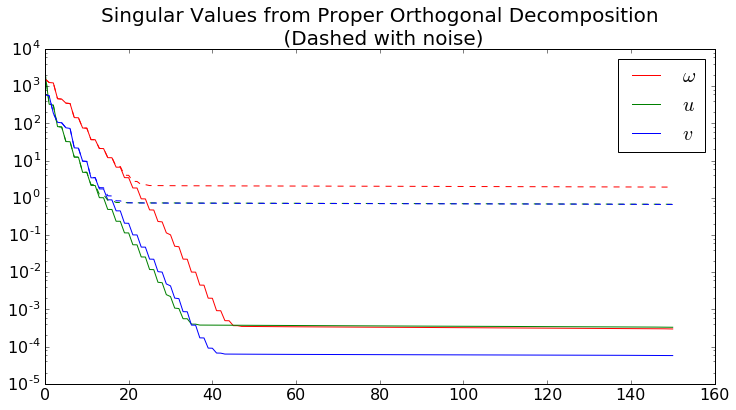

In [5]:
# singular values of clean data
semilogy(np.arange(151),sigmaw, 'r', label = r'$\omega$')
semilogy(np.arange(151),sigmau, 'g', label = r'$u$')
semilogy(np.arange(151),sigmav, 'b', label = r'$v$')

# singular values of noisy data
semilogy(np.arange(151),sigmawn, '--',color ='r')
semilogy(np.arange(151),sigmaun, '--',color ='g')
semilogy(np.arange(151),sigmavn, '--',color ='b')

legend(loc = 'upper right', fontsize = 20)
xticks(fontsize = 16)
yticks(fontsize = 16)

title('Singular Values from Proper Orthogonal Decomposition\n (Dashed with noise)', fontsize = 20)

In [6]:
dim_w = 26
dim_u = 20
dim_v = 20

Wn = uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)).reshape(n,m,steps)
Un = uun[:,0:dim_u].dot(np.diag(sigmaun[0:dim_u]).dot(vun[:,0:dim_u].T)).reshape(n,m,steps)
Vn = uvn[:,0:dim_v].dot(np.diag(sigmavn[0:dim_v]).dot(vvn[:,0:dim_v].T)).reshape(n,m,steps)

## Sample data points

Now collect a sample of points to use for PDE-FIND.  Here we take 5000 spatial points and 60 time points at each.

In [7]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
num_xy = 5000
num_t = 60
num_points = num_xy * num_t
boundary = 5
boundary_x = 10
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
    y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,2*t+12]
        count = count + 1

## Construct $\Theta (U)$ and compute $U_t$

Take derivatives and assemble into $\Theta(\omega, u ,v)$

In [8]:
# Take derivatives of vorticity at each point.  Not the most elegant way of doing this...
#PolyDiffPoint(array of fcn vals, domain vals, degree, derivatives to take): -> array of derivatives  

# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

N = 2*boundary-1  # odd number of points to use in fitting
Nx = 2*boundary_x-1  # odd number of points to use in fitting
deg = 5 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    w[p] = Wn[x,y,t]
    u[p] = Un[x,y,t]
    v[p] = Vn[x,y,t]
    
    wt[p] = PolyDiffPoint(Wn[x,y,t-(N-1)/2:t+(N+1)/2], np.arange(N)*dt, deg, 1)[0]
    
    x_diff = PolyDiffPoint(Wn[x-(Nx-1)/2:x+(Nx+1)/2,y,t], np.arange(Nx)*dx, deg, 2)
    y_diff = PolyDiffPoint(Wn[x,y-(N-1)/2:y+(N+1)/2,t], np.arange(N)*dy, deg, 2)
    wx[p] = x_diff[0]
    wy[p] = y_diff[0]
    
    x_diff_yp = PolyDiffPoint(Wn[x-(Nx-1)/2:x+(Nx+1)/2,y+1,t], np.arange(Nx)*dx, deg, 2)
    x_diff_ym = PolyDiffPoint(Wn[x-(Nx-1)/2:x+(Nx+1)/2,y-1,t], np.arange(Nx)*dx, deg, 2)
    
    wxx[p] = x_diff[1]
    wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
    wyy[p] = y_diff[1]

In [9]:
# Form a huge matrix using up to quadratic polynomials in all variables.
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])

These are all the cadidate functions which we are selecting from.

In [10]:
description

['',
 'w_{x}',
 'w_{y}',
 'w_{xx}',
 'w_{xy}',
 'w_{yy}',
 'uv',
 'v^2',
 'u^2',
 'w',
 'wu',
 'v',
 'wv',
 'u',
 'w^2',
 'uvw_{x}',
 'v^2w_{x}',
 'u^2w_{x}',
 'ww_{x}',
 'wuw_{x}',
 'vw_{x}',
 'wvw_{x}',
 'uw_{x}',
 'w^2w_{x}',
 'uvw_{y}',
 'v^2w_{y}',
 'u^2w_{y}',
 'ww_{y}',
 'wuw_{y}',
 'vw_{y}',
 'wvw_{y}',
 'uw_{y}',
 'w^2w_{y}',
 'uvw_{xx}',
 'v^2w_{xx}',
 'u^2w_{xx}',
 'ww_{xx}',
 'wuw_{xx}',
 'vw_{xx}',
 'wvw_{xx}',
 'uw_{xx}',
 'w^2w_{xx}',
 'uvw_{xy}',
 'v^2w_{xy}',
 'u^2w_{xy}',
 'ww_{xy}',
 'wuw_{xy}',
 'vw_{xy}',
 'wvw_{xy}',
 'uw_{xy}',
 'w^2w_{xy}',
 'uvw_{yy}',
 'v^2w_{yy}',
 'u^2w_{yy}',
 'ww_{yy}',
 'wuw_{yy}',
 'vw_{yy}',
 'wvw_{yy}',
 'uw_{yy}',
 'w^2w_{yy}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [11]:
lam = 10**-5
d_tol = 5
c = TrainSTRidge(X,wt,lam,d_tol)
print_pde(c, description, ut = 'w_t')

w_t = (0.010707 +0.000000i)w_{xx}
    + (0.008346 +0.000000i)w_{yy}
    + (-0.987655 +0.000000i)uw_{x}
    + (-0.982926 +0.000000i)vw_{y}
   


In [12]:
err = abs(np.array([0.010707-0.01, 0.008346-0.01, -0.987655+1, -0.982926+1]))
print mean(err)*100
print std(err)*100

0.7945
0.697610145425
